In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import read_csv, pivot_table
from pandas import DataFrame, MultiIndex, concat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
buil = pd.read_csv('building_info.csv')

In [3]:
data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB
None


In [4]:
data.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

In [5]:
# import missingno as msno
# msno.matrix(data, figsize=(8,4))
# plt.show()

In [6]:
# 열이름 영어로 다 바꾸기
# 전에 num_data_time이랑 일시량 겹치는 부분이 있으니 num_date_time을 지우고
# 나머지를 영어 이름으로 바꾸기
# 같은 주제로 일사와 일조는 시간적인/ 물리적인 에너지량을 다루기 떄문에
# 일사량 삭제
data = data.drop(['num_date_time', '일사(MJ/m2)','일시'], axis=1)

data.columns = ['building_number', 'temperature', 'precipitation','wind','Humidity','sunshine', 'kwh']

In [7]:
# 결측치를 특정 값으로 채우기
train = data.fillna(0)
train

,building_number,temperature,precipitation,wind,Humidity,sunshine,kwh
0,1,18.6,0.0,0.9,42.0,0.0,1085.28
1,1,18.0,0.0,1.1,45.0,0.0,1047.36
2,1,17.7,0.0,1.5,45.0,0.0,974.88
3,1,16.7,0.0,1.4,48.0,0.0,953.76
4,1,18.4,0.0,2.8,43.0,0.0,986.40
...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,0.5,881.04
203996,100,22.4,0.0,1.3,86.0,0.0,798.96
203997,100,21.3,0.0,1.0,92.0,0.0,825.12
203998,100,21.0,0.0,0.3,94.0,0.0,640.08


In [8]:
train.isnull().sum()

building_number    0
temperature        0
precipitation      0
wind               0
Humidity           0
sunshine           0
kwh                0
dtype: int64

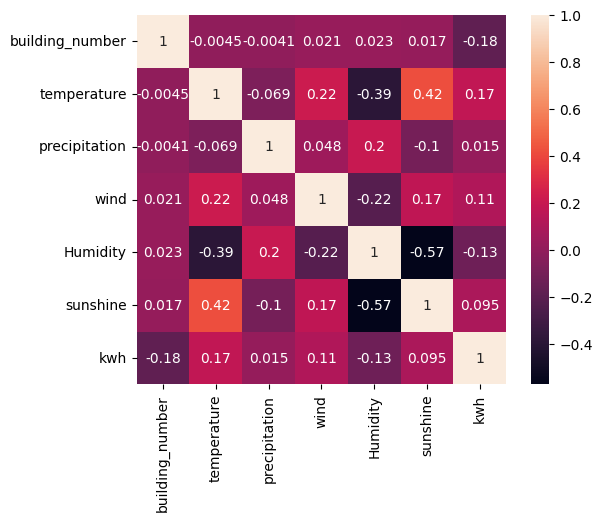

In [9]:
sns.heatmap(data=train.corr(), square=True, annot=True, cbar=True)
plt.show()

In [10]:
corr_order = train.corr().loc[:'sunshine', 'kwh'].abs().sort_values(ascending=False)
corr_order

building_number    0.180474
temperature        0.171190
Humidity           0.129373
wind               0.109956
sunshine           0.094748
precipitation      0.015083
Name: kwh, dtype: float64

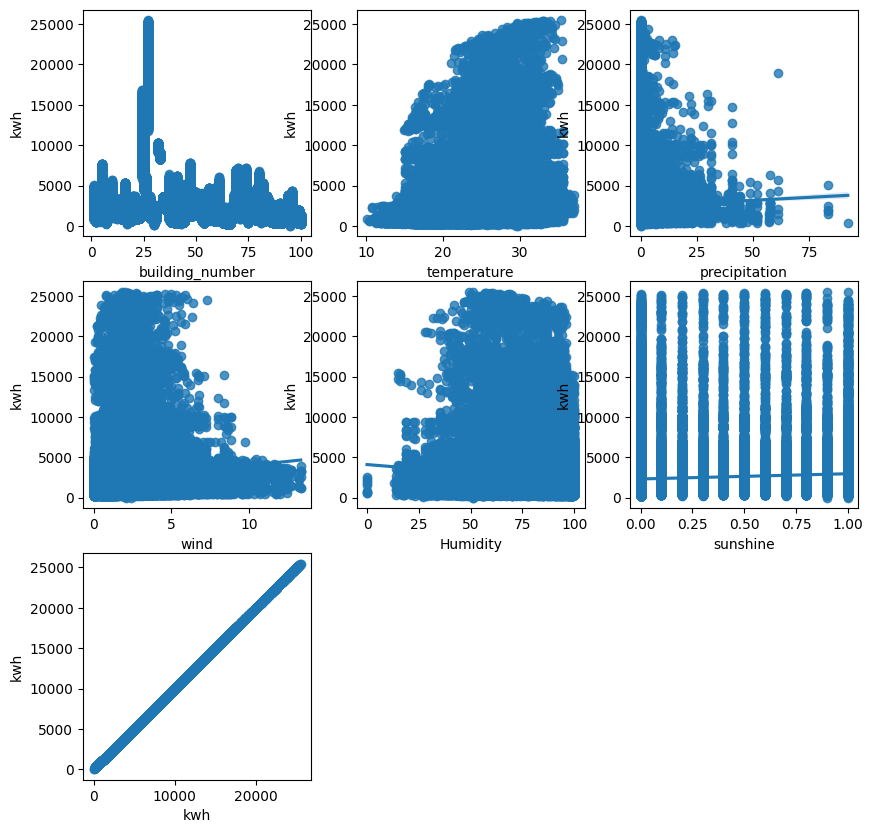

In [11]:
plt.figure(figsize=(10,10))
for idx, col in enumerate(train):
    axl = plt.subplot(3, 3, idx+1)
    sns.regplot(x=col, y=train[['kwh']], data=train, ax=axl)
plt.show()

In [12]:
df = train.drop(['sunshine', 'precipitation'], axis=1)
df

,building_number,temperature,wind,Humidity,kwh
0,1,18.6,0.9,42.0,1085.28
1,1,18.0,1.1,45.0,1047.36
2,1,17.7,1.5,45.0,974.88
3,1,16.7,1.4,48.0,953.76
4,1,18.4,2.8,43.0,986.40
...,...,...,...,...,...
203995,100,23.1,0.9,86.0,881.04
203996,100,22.4,1.3,86.0,798.96
203997,100,21.3,1.0,92.0,825.12
203998,100,21.0,0.3,94.0,640.08


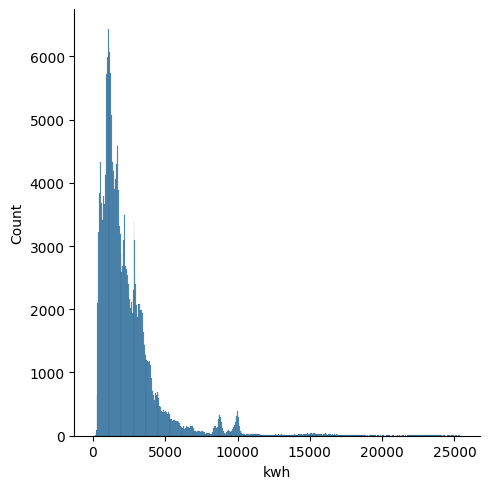

In [13]:
sns.displot(x='kwh', kind='hist', data=df)
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_scaled = df.iloc[:,:]
scaler.fit(df_scaled)
df_scaled = scaler.transform(df_scaled)

#스케일링 변환 된 값을 데이터프레임에 반영
df.iloc[:,:] = df_scaled[:,:]
df.head()

,building_number,temperature,wind,Humidity,kwh
0,0.0,0.314815,0.067669,0.42,0.042579
1,0.0,0.292593,0.082707,0.45,0.041092
2,0.0,0.281481,0.112782,0.45,0.038248
3,0.0,0.244444,0.105263,0.48,0.037419
4,0.0,0.307407,0.210526,0.43,0.038700


In [17]:
df.describe()

,building_number,temperature,wind,Humidity,kwh
count,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000
mean,0.500000,0.571982,0.160439,0.787128,0.096163
std,0.291577,0.139982,0.102120,0.150888,0.095755
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.492593,0.090226,0.690000,0.042598
50%,0.500000,0.577778,0.150376,0.810000,0.069302
75%,0.750000,0.666667,0.210526,0.910000,0.116524
max,1.000000,1.000000,1.000000,1.000000,1.000000


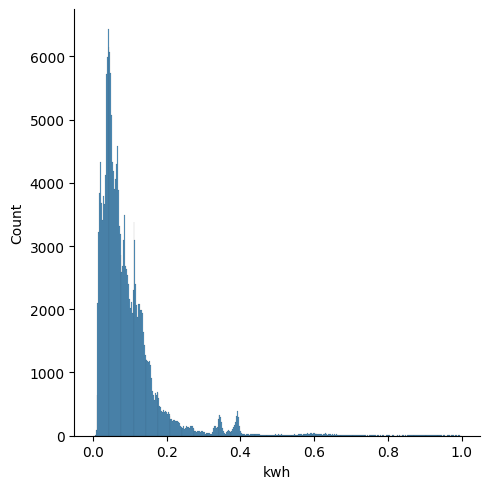

In [18]:
sns.displot(x='kwh', kind='hist', data=df)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_data = df.loc[:,['building_number', 'temperature', 'wind', 'Humidity']]
y_data = df.loc[:, 'kwh']
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=True, random_state=12)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(163200, 4) (163200,)
(40800, 4) (40800,)


In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
print("회귀계수(기울기):", np.round(lr.coef_, 1))
print("상수항(절편):", np.round(lr.intercept_, 1))

회귀계수(기울기): [-0.1  0.1  0.1 -0. ]
상수항(절편): 0.1


In [ ]:
x_test

,building_number,temperature,wind,Humidity
134899,0.666667,0.437037,0.187970,0.72
12930,0.060606,0.618519,0.218045,0.69
140368,0.686869,0.577778,0.112782,0.96
161221,0.797980,0.729630,0.172932,0.38
463,0.000000,0.459259,0.075188,0.90
...,...,...,...,...
127009,0.626263,0.529630,0.105263,0.75
133402,0.656566,0.722222,0.075188,0.67
112117,0.545455,0.785185,0.045113,0.73
158151,0.777778,0.718519,0.240602,0.62


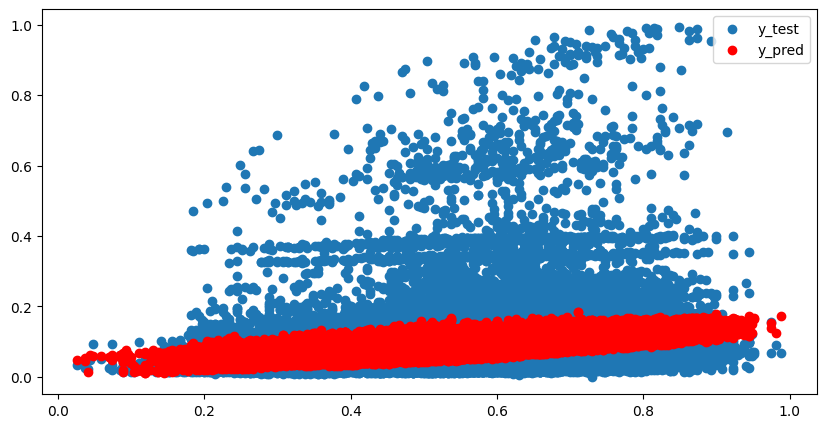

In [ ]:
# 예측
y_test_pred = lr.predict(x_test)

# 예측값 실제값의 분포
plt.figure(figsize=(10,5)) # 그림또는 도표로 나타내기
plt.scatter(x_test['temperature'], y_test, label='y_test')
plt.scatter(x_test['temperature'], y_test_pred, c='r', label='y_pred')
plt.legend(loc='best')
plt.show()

In [ ]:
# 평가
from sklearn.metrics import mean_squared_error
y_train_pred = lr.predict(x_train)

train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%3f" % train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE: %3f" % test_mse)

Train MSE:0.008454
Test MSE: 0.008798


In [ ]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
mse_score = -1*cross_val_score(lr, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("개별 Fold의 MSE:", np.round(mse_score, 4))
print("평균 MSE:%4f" % np.mean(mse_score))

개별 Fold의 MSE: [0.0082 0.0084 0.0084 0.0084 0.0089]
평균 MSE:0.008454


In [ ]:
실제집값 = df['kwh']
실제집값

0         0.042579
1         0.041092
2         0.038248
3         0.037419
4         0.038700
            ...   
203995    0.034566
203996    0.031346
203997    0.032372
203998    0.025113
203999    0.021196
Name: kwh, Length: 204000, dtype: float64

In [ ]:
from sklearn.linear_model import Ridge
rdg = Ridge(alpha=2.5) # 알파값으로 강도를 조정
rdg.fit(x_train_poly, y_train)

y_train_pred = rdg.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%.4f" % train_mse)
y_test_pred = rdg.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%.4f" % test_mse)

NameError: name 'x_train_poly' is not defined